In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from itertools import combinations


/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/2471622332.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
import seaborn as sns

### The source code of the project. In this notebook the preprocessing is done using random oversampling and not the mix with SMOTE. The oversampling method can be changed in the code block for the preprocessing.

# Data preparation

In [4]:
train_data = pd.read_csv('aps_failure_training_set.csv')
test_data = pd.read_csv('aps_failure_test_set.csv')

In [5]:
train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


#  [ag , ay , az , ba , cn , cs , ee]

In [6]:
hist_feat_names = ['ag' , 'ay' , 'az' , 'ba' , 'cn' , 'cs' , 'ee']
data_point = 5
X_vals = [] # rows are the values in the bins, each row is a feature
for feat in range(len(hist_feat_names)):
    bin_vals = []
    for hist in range(10):
        curr_hist = hist_feat_names[feat] + '_00' + str(hist)
        value = train_data.iloc[5][curr_hist]
        bin_vals.append(float(value))
    X_vals.append(bin_vals)

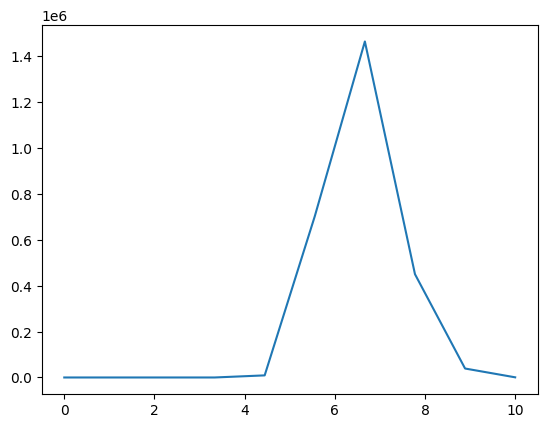

[0.0, 0.0, 0.0, 0.0, 9128.0, 701702.0, 1462836.0, 449716.0, 39000.0, 660.0]


In [7]:

x=np.linspace(0,10,10)
y = []
for i in range(len(x)):
    y.append(float(X_vals[0][i]))
plt.plot(x,y)
# Show the plot
plt.show()
print(y)

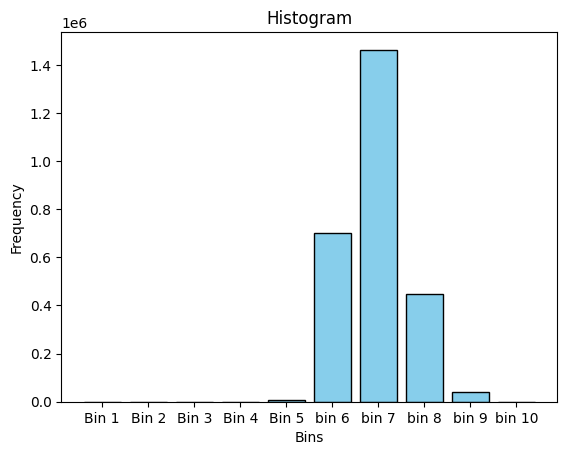

In [8]:
bins = ['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'bin 6', 'bin 7', 'bin 8', 'bin 9', 'bin 10']

plt.bar(bins, height=X_vals[0], color='skyblue', edgecolor='black')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

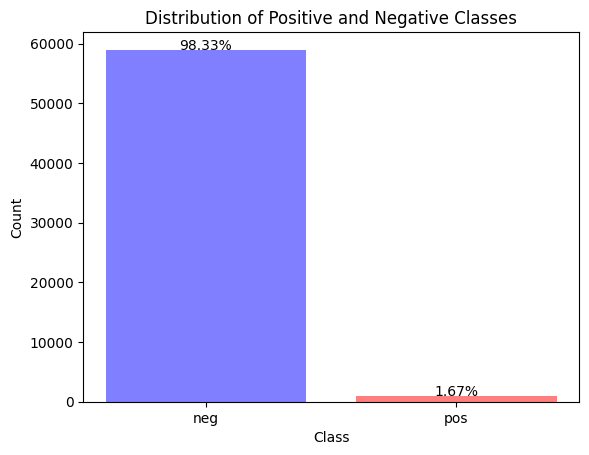

In [9]:
class_counts = train_data['class'].value_counts()

total_samples = len(train_data)
positive_percentage = (class_counts['pos'] / total_samples) * 100
negative_percentage = (class_counts['neg'] / total_samples) * 100

# Plotting
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'], alpha=0.5)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Positive and Negative Classes')
plt.text(1, class_counts['pos'], f'{positive_percentage:.2f}%', ha='center')
plt.text(0, class_counts['neg'], f'{negative_percentage:.2f}%', ha='center')
plt.show()

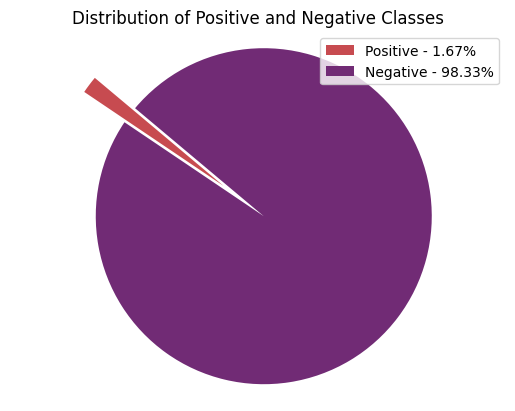

In [10]:
# Plotting
labels = ['Positive - 1.67%', 'Negative - 98.33%']
sizes = [positive_percentage, negative_percentage]
colors = ['#C74B50', '#712B75']
explode = (0.3, 0)  # explode the 1st slice (Positive)

patches, texts = plt.pie(sizes, explode=explode, colors=colors, shadow=False, startangle=140, wedgeprops = {"linewidth": 0, "edgecolor": "white"})
plt.axis('equal')
plt.title('Distribution of Positive and Negative Classes')
plt.legend(labels=labels)
plt.show()

/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/701508007.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(bins, rotation=90)
/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/701508007.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(bins, rotation=90)
/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/701508007.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(bins, rotation=90)
/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/701508007.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(bin

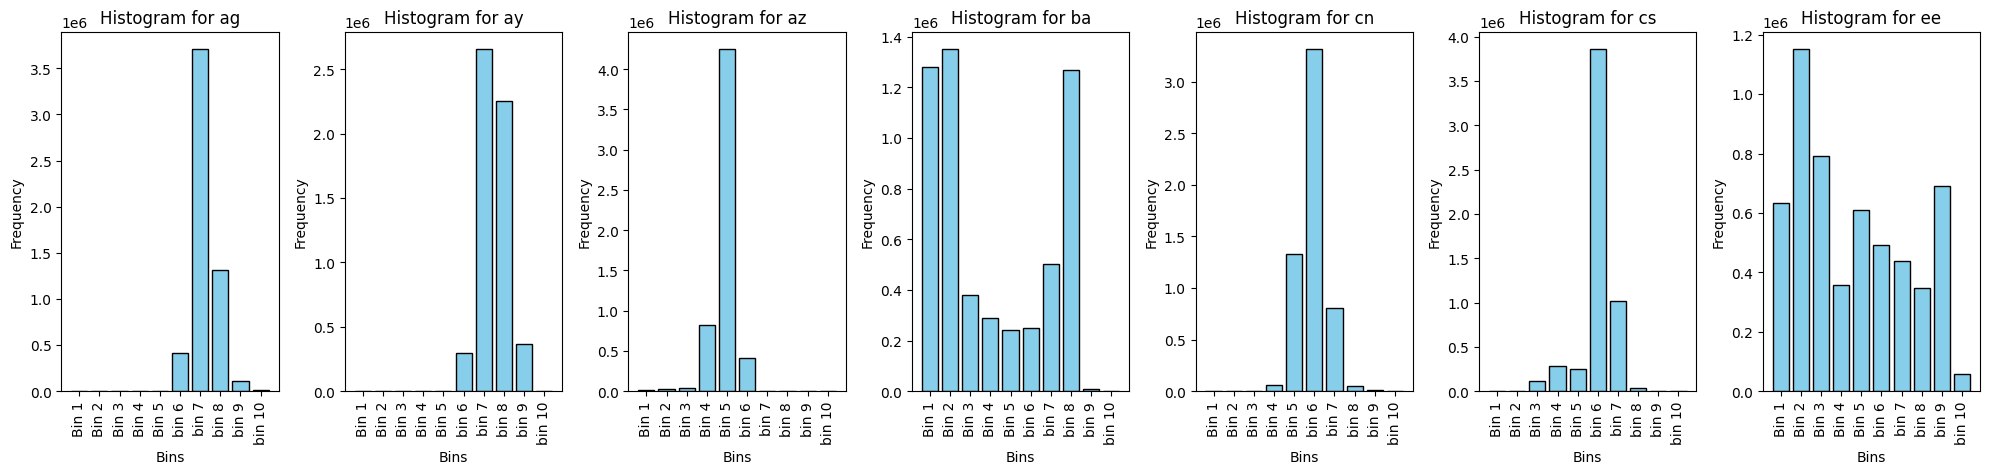

In [11]:
hist_feat_names = ['ag' , 'ay' , 'az' , 'ba' , 'cn' , 'cs' , 'ee']
data_point = 50576
X_vals_pos = [] # rows are the values in the bins, each row is a feature. 
for feat in range(len(hist_feat_names)):
    bin_vals = []
    for hist in range(10):
        curr_hist = hist_feat_names[feat] + '_00' + str(hist)
        value = train_data.iloc[50576][curr_hist]
        bin_vals.append(float(value))
    X_vals_pos.append(bin_vals)


#plot
fig, axs = plt.subplots(1, len(hist_feat_names), figsize=(20, 5))
for i, feat_name in enumerate(hist_feat_names):
    axs[i].bar(bins, height=X_vals_pos[i], color='skyblue', edgecolor='black');
    axs[i].set_xlabel('Bins')
    axs[i].set_xticklabels(bins, rotation=90)
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram for {feat_name}')

plt.tight_layout()
plt.show();

neg -> 0

pos -> 1

In [12]:
train_data = train_data.apply(pd.to_numeric, errors='ignore');
test_data = test_data.apply(pd.to_numeric, errors='ignore');

/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/1092299916.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  train_data = train_data.apply(pd.to_numeric, errors='ignore')
/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/1092299916.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  test_data = test_data.apply(pd.to_numeric, errors='ignore')


In [13]:
print(train_data)

      class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg   76698     na  2130706438    280      0      0      0      0   
1       neg   33058     na           0     na      0      0      0      0   
2       neg   41040     na         228    100      0      0      0      0   
3       neg      12      0          70     66      0     10      0      0   
4       neg   60874     na        1368    458      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995   neg  153002     na         664    186      0      0      0      0   
59996   neg    2286     na  2130706538    224      0      0      0      0   
59997   neg     112      0  2130706432     18      0      0      0      0   
59998   neg   80292     na  2130706432    494      0      0      0      0   
59999   neg   40222     na         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  ee_007  ee_0

In [14]:
print(test_data)

      class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg      60      0          20     12      0      0      0      0   
1       neg      82      0          68     40      0      0      0      0   
2       neg   66002      2         212    112      0      0      0      0   
3       neg   59816     na        1010    936      0      0      0      0   
4       neg    1814     na         156    140      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
15995   neg   81852     na  2130706432    892      0      0      0      0   
15996   neg      18      0          52     46      8     26      0      0   
15997   neg   79636     na        1670   1518      0      0      0      0   
15998   neg     110     na          36     32      0      0      0      0   
15999   neg       8      0           6      4      2      2      0      0   

      ag_002  ...  ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008 

In [15]:
train_data['class'] = train_data['class'].map({'neg': 0, 'pos': 1})
test_data['class'] = test_data['class'].map({'neg': 0, 'pos': 1})

In [16]:
train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,0,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,0,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,0,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


## filling missing values

In [17]:
x_train = train_data.drop(['class'], axis=1)
x_test = test_data.drop(['class'], axis=1)

y_train = train_data['class']
y_test = test_data['class']

In [18]:
# replace 'na' with np.nan float
x_train.replace('na', np.nan, inplace=True)
x_test.replace('na', np.nan, inplace=True) 

/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_28800/1751029214.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_counts_sorted.index, y=na_counts_sorted.values, palette="coolwarm")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  

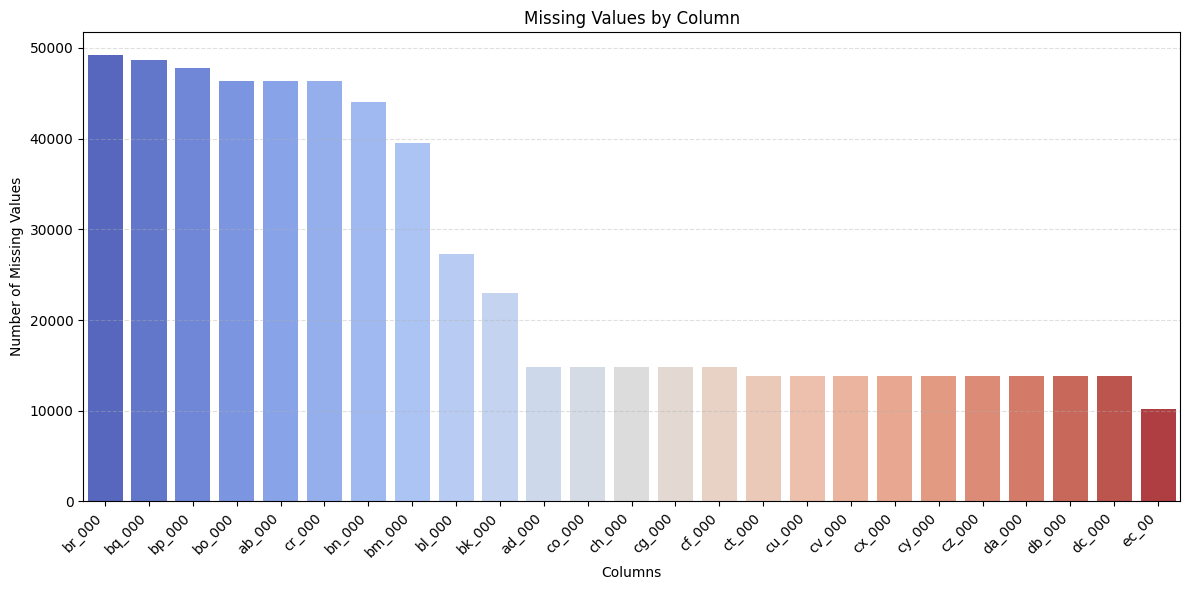

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

na_counts = x_train.isna().sum()

# drop the features that have too many NA values (more than 35,000)
bad_features = na_counts[na_counts > 35000].index
x_train = x_train.drop(columns=bad_features)
x_test = x_test.drop(columns=bad_features)

# filter for features with more than 10,000 missing values
na_counts_filtered = na_counts[na_counts > 10000]

#Sort the features by the number of missing values in ascending order
na_counts_sorted = na_counts_filtered.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=na_counts_sorted.index, y=na_counts_sorted.values, palette="coolwarm");
plt.title('Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# save the column names
column_names = x_train.columns


In [21]:
import pipelines as pipe

In [22]:
print(type(x_train))

<class 'pandas.core.frame.DataFrame'>


# From here we use pipelines

In [23]:
x_train, x_test, y_train, y_test = pipe.pipeline(x_train, x_test, y_train, y_test,
                                                scaler='standard',
                                                imputer='median',
                                                oversampling='random',
                                                VIF='no')
x_train[0]

array([ 1.19381409e-01,  2.23268818e+00, -4.71093975e-03, -4.22127481e-02,
       -5.24656899e-02, -1.08229912e-02, -2.85296894e-02, -5.72510040e-02,
       -1.16303532e-01, -1.68408816e-01,  9.94581564e-02,  5.13215153e-01,
        3.57317375e-01, -4.39421728e-02, -3.01476569e-02,  1.77213838e-01,
       -5.52251368e-02, -2.27103065e-02, -1.29167594e-02, -1.09610233e-01,
       -1.09812217e-01,  1.88986555e-01,  9.57151442e-02,  2.46678148e-01,
        5.46264025e-01, -9.01585794e-02, -1.15110906e-02, -4.24031204e-02,
       -1.45942595e-02, -1.60377425e-02, -7.17120597e-02, -2.68687560e-02,
       -1.90374798e-02, -2.56225625e-02, -3.49974289e-02, -2.97950370e-02,
        2.56017266e-01,  9.64071952e-01, -1.65043126e-01, -7.39778973e-02,
       -1.18683330e-02, -3.36194653e-02, -6.80389841e-02, -3.70743444e-02,
       -1.14646375e-01, -2.05936424e-01,  5.24861420e-01, -1.10602824e-01,
       -6.19515102e-02, -4.43418851e-02, -1.29196703e-02,  2.45983426e-01,
        5.46408790e-02,  

In [24]:
x_train.shape

(118000, 162)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


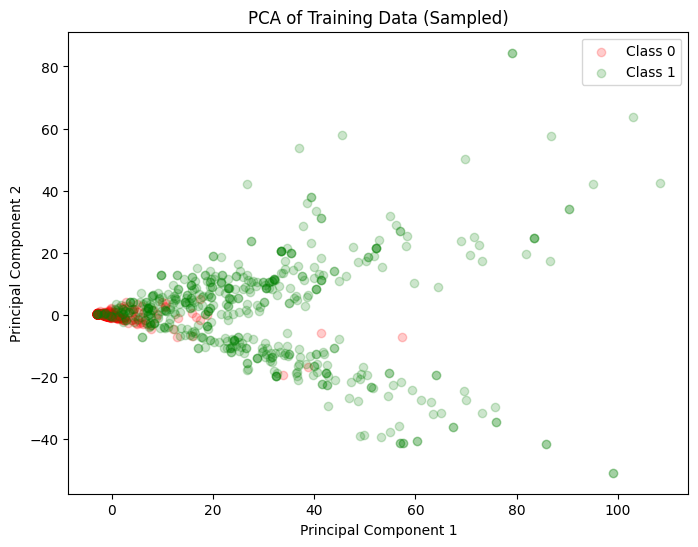

In [89]:
# sample 1000 data points
random_indices = np.random.choice(x_train.shape[0], size=1000, replace=False)
x_train_sampled = x_train[random_indices]
y_train_sampled = y_train[random_indices]

# covariance matrix
cov_matrix = np.cov(x_train_sampled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

n_components = 2
top_eigenvectors = eigenvectors[:, :n_components]

x_train_pca = np.dot(x_train_sampled, top_eigenvectors)

# Plot
plt.figure(figsize=(8, 6))
classes = np.unique(y_train_sampled)
colors = ['r', 'g']

for cls, color in zip(classes, colors):
    idx = np.where(y_train_sampled == cls)
    plt.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], c=color, label=f'Class {cls}', alpha=0.2)

plt.title('PCA of Training Data (Sampled)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


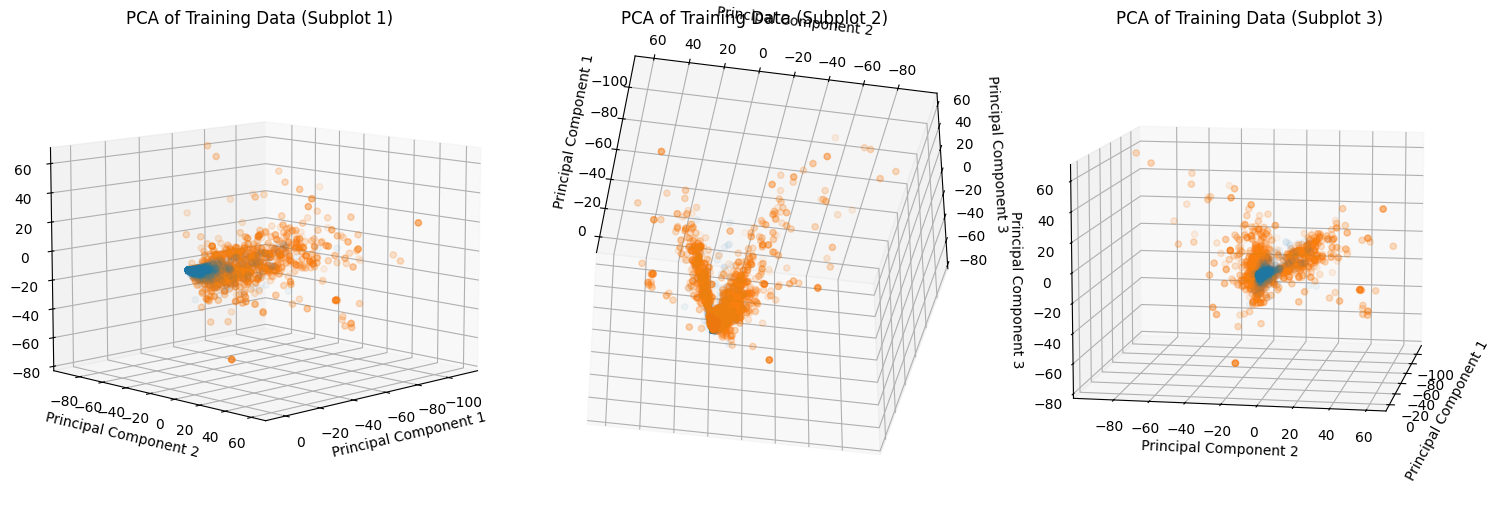

In [90]:
# pca
random_indices = np.random.choice(x_train.shape[0], size=10000, replace=False)
x_train_sampled = x_train[random_indices]
y_train_sampled = y_train[random_indices]

cov_matrix = np.cov(x_train_sampled, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

n_components = 3
top_eigenvectors = eigenvectors[:, :n_components]

x_train_pca = np.dot(x_train_sampled, top_eigenvectors)

#plot
fig = plt.figure(figsize=(15, 5))
angles = [(10, 45), (-40, 170), (10, 10)]
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.set_title(f'PCA of Training Data (Subplot {i+1})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    for cls in np.unique(y_train_sampled):
        idx = np.where(y_train_sampled == cls)
        ax.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], x_train_pca[idx, 2], label=f'Class {cls}', alpha=0.05)
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()

# san cone, ta negatives einai mazemena sti myth


In [92]:
x_train_df = pd.DataFrame(x_train, columns=column_names)

x_train_numerical = [col for col in x_train_df.columns if '000' in col]
x_train_numerical = x_train_df[x_train_numerical]
x_train_numerical = x_train_numerical.to_numpy()
x_train_numerical = pipe.MedianImputerFunction_OneSet(x_train_numerical)
x_train_numerical = pipe.StandardScalerFunction_OneSet(x_train_numerical)
pipe.getVIF(x_train_numerical)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


0          145.75
1            1.16
2    138379854.56
3            3.50
4            3.52
         ...     
92           1.81
93           4.12
94          13.72
95           2.96
96           1.29
Name: VIF, Length: 97, dtype: float64


# Testing models

## Neural 

In [ ]:

m = tf.keras.metrics.FalseNegatives()
rec = tf.keras.metrics.Recall()
# to categorical
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# model
model = Sequential([
    Dense(64, input_dim=x_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[m,rec,'accuracy'])
model.fit(x_train, y_train_encoded, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200
2950/2950 [==============================] - 3s 938us/step - loss: 0.0996 - false_negatives_4: 2831.0000 - recall_1: 0.9700 - accuracy: 0.9700 - val_loss: 0.0966 - val_false_negatives_4: 489.0000 - val_recall_1: 0.9793 - val_accuracy: 0.9793
Epoch 2/200
2950/2950 [==============================] - 2s 816us/step - loss: 0.0576 - false_negatives_4: 1425.0000 - recall_1: 0.9849 - accuracy: 0.9849 - val_loss: 0.0586 - val_false_negatives_4: 362.0000 - val_recall_1: 0.9847 - val_accuracy: 0.9847
Epoch 3/200
2950/2950 [==============================] - 2s 838us/step - loss: 0.0426 - false_negatives_4: 1012.0000 - recall_1: 0.9893 - accuracy: 0.9893 - val_loss: 0.0710 - val_false_negatives_4: 392.0000 - val_recall_1: 0.9834 - val_accuracy: 0.9834
Epoch 4/200
2950/2950 [==============================] - 2s 833us/step - loss: 0.0356 - false_negatives_4: 856.0000 - recall_1: 0.9909 - accuracy: 0.9909 - val_loss: 0.0459 - val_false_negatives_4: 288.0000 - val_recall_1: 0.9878 - val_ac

In [ ]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1}')

conf_m = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_m)

tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)
print(f'Test Cost: {cost}')

500/500 [==============================] - 0s 418us/step
Macro F1 Score: 0.8824743943065881
Confusion Matrix:
[[15553    72]
 [   95   280]]
Test Cost: 48220


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

## making a scorer

In [25]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [26]:
def custom_scoring_function(y_true, y_pred):
    conf_m = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_m.ravel()
    cost = (10 * fp) + (500 * fn)
    return cost

scorer = make_scorer(custom_scoring_function, greater_is_better=False)

## Random Forest

Best parameters found: {'max_depth': 5, 'n_estimators': 22}
Best score found: 0.9628813549788011
 macro f1 = 0.7322478810990833
Test Cost :  10630
[[14862   763]
 [    6   369]]
(16000,)
(16000,)


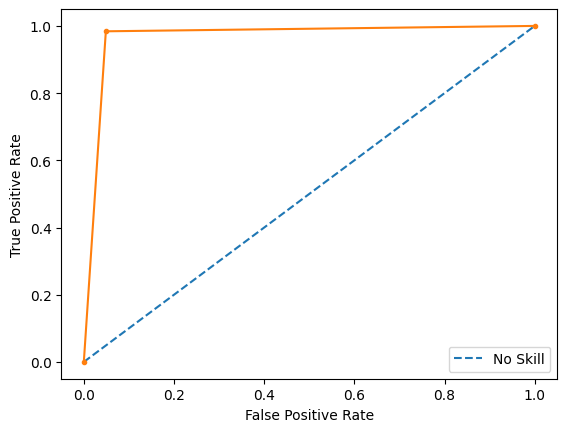

In [ ]:

rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [5], #[3,5,7,9]
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


## Logistic

In [ ]:

x_train_df = pd.DataFrame(x_train)

# VIF dataframe 
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(x_train_df.values, i) 
                          for i in range(len(x_train_df.columns))] 
  
print(vif_data)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

print(f'{vif_data["VIF"].round(2)}')

x_test_df = pd.DataFrame(x_test)

high_vif_features = vif_data[vif_data["VIF"] > 20]["feature"]
x_train_vif = x_train_df.drop(columns=high_vif_features)
x_test_vif = x_test_df.drop(columns=high_vif_features)
print(x_train_vif.head())

x_train_vif = x_train_vif.to_numpy()
x_test_vif = x_test_vif.to_numpy()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


     feature          VIF
0          0       234.70
1          1         1.27
2          2 159348518.95
3          3         3.54
4          4         3.58
..       ...          ...
157      157    380621.40
158      158     89548.77
159      159       849.76
160      160         3.17
161      161         1.32

[162 rows x 2 columns]
0           234.70
1             1.27
2     159348518.95
3             3.54
4             3.58
          ...     
157      380621.40
158       89548.77
159         849.76
160           3.17
161           1.32
Name: VIF, Length: 162, dtype: float64
    1     3     4     16    17    18   ...   146   147   148   149   160   161
0  2.23 -0.04 -0.05 -0.06 -0.02 -0.01  ... -0.03 -0.16  0.31  0.36 -0.02 -0.02
1 -0.45 -0.04 -0.05 -0.06 -0.02 -0.01  ... -0.03 -0.15  0.24  0.25 -0.02 -0.02
2 -0.45 -0.04 -0.05 -0.06 -0.02 -0.01  ... -0.03 -0.20 -0.09 -0.12 -0.02 -0.02
3 -0.45 -0.04 -0.00 -0.06 -0.02 -0.01  ... -0.03 -0.23 -0.38 -0.40  0.89  3.60
4 -0.45 -0.04 -0.05 -

In [ ]:

lr = LogisticRegression(class_weight={0:1, 1:2},random_state=42)
lr.fit(x_train_vif, y_train)

y_pred = lr.predict(x_test_vif)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()

cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)
print(conf_m)

Test Cost :  17500
[[14825   800]
 [   19   356]]


## Tuned Ridge

In [ ]:

alpha =[i/50 for i in range(1,50)]
param_grid = {'alpha': alpha}

ridge = RidgeClassifier(class_weight={0:1, 1:2},random_state=42)
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring=scorer, cv=6, n_jobs=-1, verbose=True)
grid_search.fit(x_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_pred_bin = np.where(y_pred >= 0.5, 1, 0)
conf_m = confusion_matrix(y_test, y_pred_bin)
tn, fp, fn, tp = conf_m.ravel()

cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)
print(conf_m)

Fitting 6 folds for each of 49 candidates, totalling 294 fits
Best parameters found:  {'alpha': 0.02}
Test Cost :  21260
[[15049   576]
 [   31   344]]


## knn

In [ ]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 9, 15]
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring=scorer, cv=5)
grid_search_knn.fit(x_train, y_train)
y_pred = grid_search_knn.predict(x_test)
best_params = grid_search_knn.best_params_
print("Best parameters found: ", best_params)

best_knn = grid_search.best_estimator_
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)

macro_f1 = f1_score(y_test, y_pred, average="macro")
print(f'Macro F1 = {macro_f1}')

conf_m = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_m)

tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost: ", cost)

Best parameters found:  {'n_neighbors': 3}
Macro F1 = 0.7557526819861944
Confusion Matrix:
 [[15049   576]
 [   31   344]]
Test Cost:  21260
